In [1]:
'''
fbp of the mayo dataset with different noise levels
'''

'\nfbp of the mayo dataset with different noise levels\n'

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import h5py
import argparse
import configparser

In [3]:
sys.path.append('..')
import CTProjector.projector.ct_projector as ct_projector

In [25]:
parser = argparse.ArgumentParser()
parser.add_argument('--input_dir', default = '/home/dwu/data/lowdoseCTsets/')
parser.add_argument('--output_dir', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo/dose_rate_1')
parser.add_argument('--name', default = 'L291_full_sino')
parser.add_argument('--geometry', default = '/home/dwu/trainData/deep_denoiser_ensemble/data/mayo/geometry.cfg')

parser.add_argument('--device', dest='device', type=int, default=0)

parser.add_argument('--N0', type=float, default = 1e5)
parser.add_argument('--dose_rate', type=float, default = 4)
parser.add_argument('--imgNorm', type=float, default=0.019)

if sys.argv[0] != 'fbp_mayo.py':
    showplot = True
    args = parser.parse_args(['--device', '2', 
                              '--name', 'L291_full_sino', 
                              '--N0', '1e5', 
                              '--dose_rate', '4'])
else:
    showplot = False
    args = parser.parse_args()

for v in vars(args):
    print (v, '=', getattr(args, v), flush=True)

projector = ct_projector.ct_projector()
projector.from_file(args.geometry)
print ('\n[projector]')
for v in vars(projector):
    print (v, '=', getattr(projector, v), flush=True)

input_dir = /home/dwu/data/lowdoseCTsets/
output_dir = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo/dose_rate_1
name = L291_full_sino
geometry = /home/dwu/trainData/deep_denoiser_ensemble/data/mayo/geometry.cfg
device = 2
N0 = 100000.0
dose_rate = 4.0
imgNorm = 0.019

[projector]
nview = 2304
nu = 736
nv = 50
nx = 640
ny = 640
nz = 1
dx = 0.75
dy = 0.75
dz = 1.0
cx = 0
cy = 0
cz = 0
dsd = 1086.5
dso = 595.0
du = 1.2858
dv = 1.0
off_u = -1.125
off_v = 0
geometry = <configparser.ConfigParser object at 0x2aac53512460>


In [26]:
# load projection
print ('Loading projection', end='...', flush=True)
with h5py.File(os.path.join(args.input_dir, args.name + '.mat'), 'r') as f:
    prj = np.copy(f['sino']).transpose([1, 0, 2]).astype(np.float32) / args.imgNorm
    prj = np.copy(prj, 'C')[np.newaxis]
print ('Done')

Loading projection...Done


In [27]:
# add noise
np.random.seed(0)
if args.N0 > 0:
    prj = prj + np.sqrt((1 - 1 / args.dose_rate) * args.dose_rate * np.exp(prj * args.imgNorm) / args.N0) * np.random.normal(size = prj.shape) / args.imgNorm
    prj = prj.astype(np.float32)

In [28]:
projector.set_device(args.device)
angles = projector.get_angles()
recons = []
batchsize = 32
for i in range(0, prj.shape[2], batchsize):
    current_prj = np.copy(prj[..., i:i+batchsize, :], 'C')
    projector.nz = current_prj.shape[2]
    sprj = projector.ramp_filter(current_prj)
    recon = projector.fbp_fan_bp(sprj, angles)
    recons.append(recon)
recons = np.concatenate(recons, 1)[0]

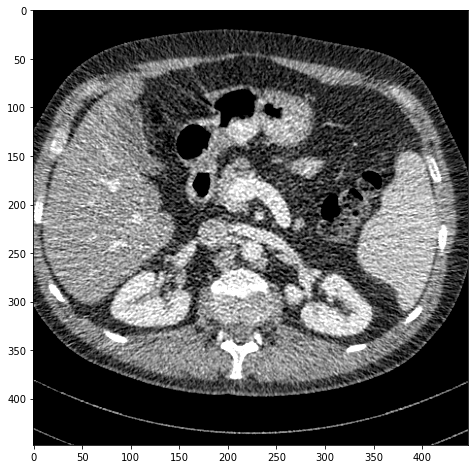

In [29]:
if showplot:
    plt.figure(figsize=[8,8])
    plt.imshow(recons[100, 96:-96, 96:-96], 'gray', vmin=0.84, vmax=1.24)

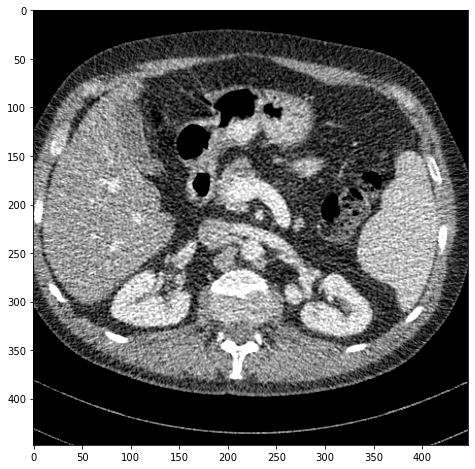

In [14]:
if showplot:
    plt.figure(figsize=[8,8])
    plt.imshow(recons[100, 96:-96, 96:-96], 'gray', vmin=0.84, vmax=1.24)

In [21]:
img = (recons * 1000 - 1000).astype(np.int16)
sitk_img = sitk.GetImageFromArray(img)
sitk_img.SetSpacing([float(projector.dx), float(projector.dy), float(projector.dz)])
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
sitk.WriteImage(sitk_img, os.path.join(args.output_dir, args.name.replace('sino', 'hann') + '.nii'))